<a href="https://colab.research.google.com/github/jasondrebber/GEOL558/blob/main/Supervised_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised Regression
## Jason Drebber

The purpose of this project is to predict average ozone concentration using various site dependent local features. The data is downloaded from a machine learning training dataset available at https://essd.copernicus.org/articles/13/3013/2021/. The data was prepared for the purpose of creating an easy to use dataset and initial code to explore regression. Here I am only utilizing the dataset and not any of the existing code provided by the data generators.

Ozone is a protective gas when it occurs in the stratosphere, however when it exists in the troposphere it is a harmful and toxic pollutant. Therefore it is important to understand where it occurs and at what levels to protect human health. This dataset contains many features which allow the prediction of the ozone concentration in an area based on known physical relationships. Primarily Ozone forms by atmospheric reactions when nitrogen compounds in the air bond with oxygen creating a free radical which bonds with oxygen gas (O2) resulting in the formation of Ozone. Therefore in areas which produce more atmospheric polution, particularly with nitrogne compounds, which can be the result of power generator stations and high populations of people with cars, Ozone levels are expected to be higher. In the following code I intend to inspect which variables are important for predicting the atmospheric concentration of Ozone in an area.

# Import Packages

In [ ]:
# Import Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Load and View Data

In [ ]:
# Load the data from github
AQ = pd.read_csv('https://raw.githubusercontent.com/jasondrebber/GEOL558/f0717e8983c3c055f3d62b8a3f06ca67e5dd165d/AQbench_dataset.csv')

In [ ]:
# View Data
AQ.head()

,id,country,htap_region,climatic_zone,lon,lat,alt,relative_alt,type,type_of_area,...,o3_perc90,o3_perc98,o3_dma8eu,o3_avgdma8epax,o3_drmdmax1h,o3_w90,o3_aot40,o3_nvgt070,o3_nvgt100,dataset
0,3336,Germany,EUR,cool_moist,8.308210,54.924970,12.0,3,background,rural,...,46.4399,54.8468,53.5738,38.8078,50.7704,86.1266,10197.4742,2.0,0.0,test
1,3338,Germany,EUR,cool_moist,12.725280,54.436670,1.0,1,background,rural,...,44.0575,53.7778,51.3996,35.8313,48.3935,69.0987,7573.2222,1.0,0.0,train
2,3339,Germany,EUR,cool_moist,6.093923,50.754704,205.0,66,background,urban,...,41.1803,58.4009,54.9030,32.6169,49.8276,154.1263,8655.4730,5.4,1.0,train
3,3340,Germany,EUR,cool_moist,8.548389,52.023169,102.0,29,background,urban,...,38.1730,53.5109,50.1112,28.6179,46.2694,120.2575,6036.5851,2.6,0.0,test
4,3341,Germany,EUR,cool_moist,6.874554,51.862000,45.0,8,background,rural,...,40.6623,58.4082,53.9564,31.0051,50.6809,203.4584,9045.4745,6.8,1.2,train


In [ ]:
# Check size
AQ.shape

(5577, 53)

In [ ]:
# Check the structure of the data
AQ.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5577 entries, 0 to 5576
Data columns (total 53 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   id                                       5577 non-null   int64  
 1   country                                  5577 non-null   object 
 2   htap_region                              5577 non-null   object 
 3   climatic_zone                            5577 non-null   object 
 4   lon                                      5577 non-null   float64
 5   lat                                      5577 non-null   float64
 6   alt                                      5577 non-null   float64
 7   relative_alt                             5577 non-null   int64  
 8   type                                     5577 non-null   object 
 9   type_of_area                             5577 non-null   object 
 10  water_25km                               5577 no

The curated dataset includes a metadata file. In the file is a table that has all of the features and what reason they were included in the data. In the list above the data are organized by category. id is just that a feature identifying each sample, it is not meant to be used for any purpose other than that. After columns 1-36 are all input values for the model and starting with "03_average_values" is a number of different target features. Any of them can be used as target features and so should be removed from the feature dataset (X). Finally dataset is specifically a train/validate/test feature which is described below but includes classes of data that the authors have used to split the data based on best practives and taking into account autocorrelation. Because id is just an id feature I will drop it from the dataset before performing EDA.

In [ ]:
# Drop the id feature from the raw data
AQ.drop(columns=['id'], inplace=True)

# Exploratory Data Analysis

In [ ]:
# Look at the summary statistics
AQ.describe()

,lon,lat,alt,relative_alt,water_25km,evergreen_needleleaf_forest_25km,evergreen_broadleaf_forest_25km,deciduous_needleleaf_forest_25km,deciduous_broadleaf_forest_25km,mixed_forest_25km,...,o3_perc75,o3_perc90,o3_perc98,o3_dma8eu,o3_avgdma8epax,o3_drmdmax1h,o3_w90,o3_aot40,o3_nvgt070,o3_nvgt100
count,5577.000000,5577.000000,5577.000000,5577.000000,5577.000000,5577.000000,5577.000000,5577.000000,5577.000000,5577.000000,...,5577.000000,5577.000000,5577.000000,5577.000000,5577.000000,5577.000000,5577.000000,5577.000000,5577.000000,5577.000000
mean,13.477650,39.302449,264.636320,49.784113,12.667886,2.884884,0.511655,0.002241,2.676529,19.817052,...,-172.774709,-164.798120,-153.907786,-133.845728,-152.661457,48.191788,-63.851527,12874.239386,-176.564118,-193.487111
std,88.079720,13.233924,466.298427,107.169033,19.386709,9.199527,4.170122,0.080375,9.027644,21.747760,...,416.565376,420.595277,426.124266,407.712741,401.688016,79.985568,471.595949,11506.274694,390.451060,396.388200
min,-170.564000,-89.996000,-4.000000,-136.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000
25%,-76.003333,35.411100,20.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.100000,...,27.568200,36.089300,45.487500,45.362200,29.143300,49.381500,30.054100,2509.572200,0.000000,0.000000
50%,7.478586,39.834461,90.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,...,35.364900,45.362200,58.356100,56.269400,36.341200,54.255300,105.015200,11957.588000,2.500000,0.000000
75%,127.115140,45.836945,287.000000,47.000000,23.400000,1.600000,0.000000,0.000000,0.000000,33.800000,...,40.000000,50.750000,65.120000,62.688900,41.255500,58.641700,194.585300,20378.611200,9.333300,0.500000
max,174.870000,82.450830,5500.000000,1826.000000,100.000000,96.400000,99.500000,4.800000,94.500000,99.100000,...,61.640000,74.872000,115.286000,108.077500,71.186100,102.152200,738.478400,72430.871300,179.500000,93.000000


The summary statistic table above is large enough that many of the entries are not shown.

In [ ]:
# Figure 1: Pair plot of all numeric variables for evaluating the trend of different features in relationship to each other
# This plot takes about 12 minutes to run, only run this cell if you want to look at the different relationships because it takes along time.
#sns.pairplot(AQ)
#plt.suptitle('Pair Plot')
#plt.show()

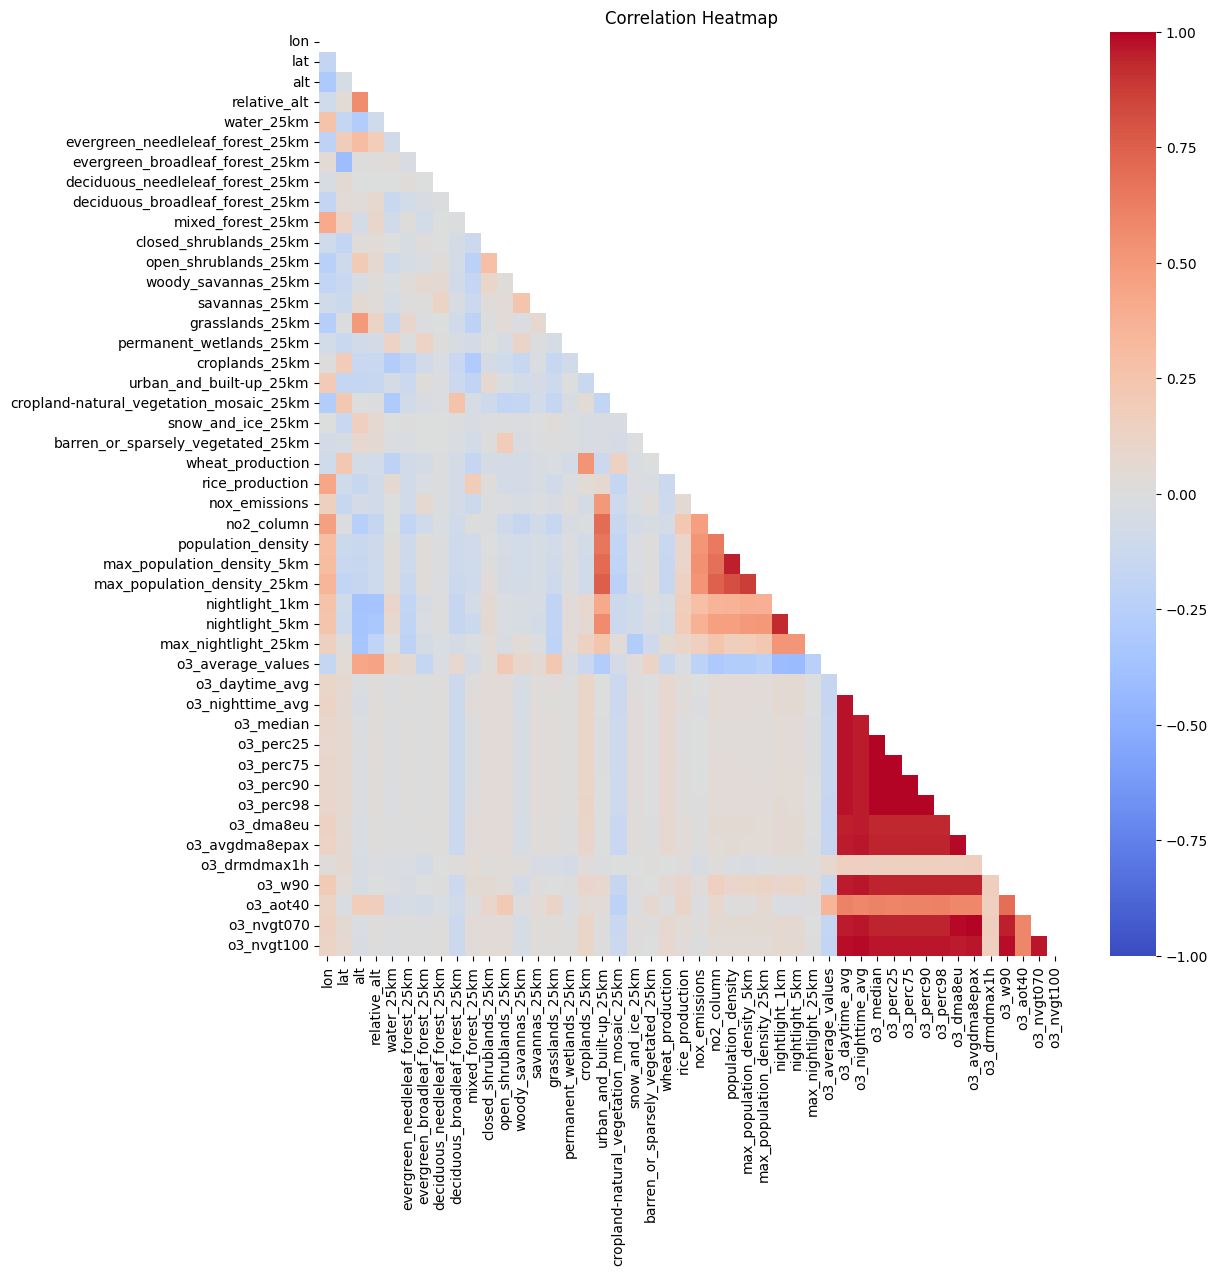

In [ ]:
# Figure 2: Correlation Heatmap with upper triangle masked out to evaluate possible linear relationships between features of the data

# Calculate the correlation
Corr = AQ.select_dtypes(include=['float64', 'int64']).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(Corr, dtype=bool))

# Plot the figure
plt.figure(figsize=(12, 12))
sns.heatmap(Corr, mask=mask, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

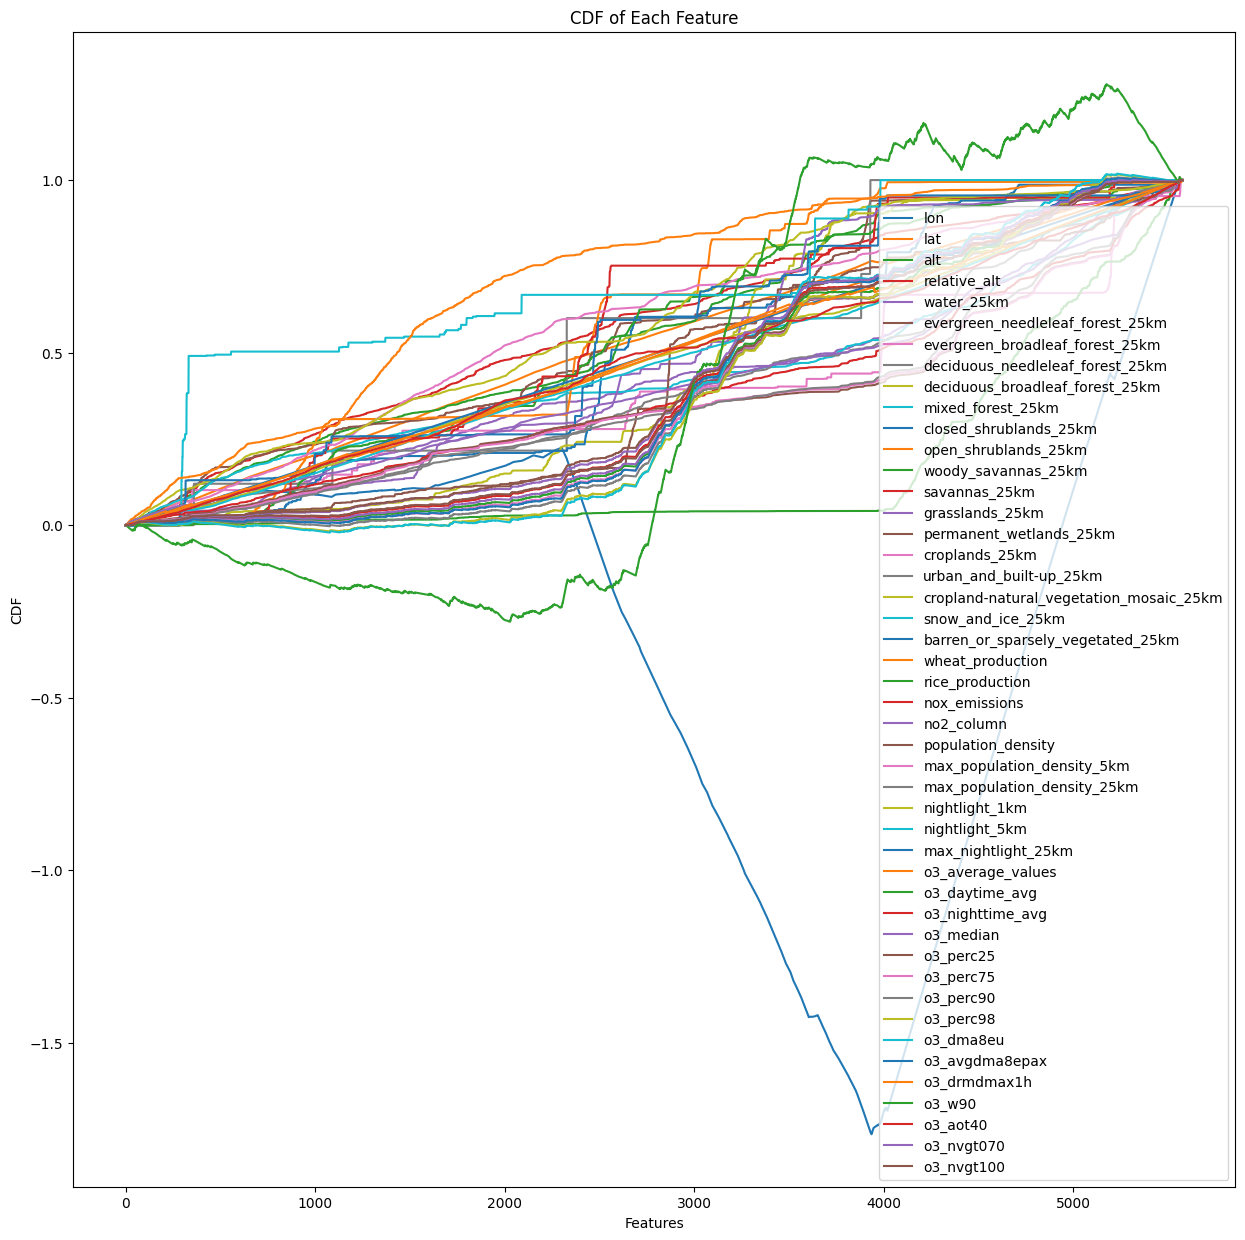

In [ ]:
# Figure 3: CDF of each feature to roughly explore the dataset

# Calculate the CDF of each feature
CDF = AQ.select_dtypes(include=['float64', 'int64']).cumsum(
    axis=0) / AQ.select_dtypes(include=['float64', 'int64']).sum(axis=0)

# Plot the CDF for each feature on the same plot
plt.figure(figsize=(15, 15))
for col in CDF.columns:
    plt.plot(CDF.index, CDF[col], label=col)
plt.title('CDF of Each Feature')
plt.xlabel('Features')
plt.ylabel('CDF')
plt.legend(loc = 'best')
plt.show()

This is interesting it appears that there are some data that have CDF values outside of the range of posisble CDF values such as negative values and above 1. I will investigate this below.

In [ ]:
# Identify which columns have negative CDF values
CDF.lt(0).any()

,0
lon,True
lat,False
alt,False
relative_alt,False
water_25km,False
evergreen_needleleaf_forest_25km,False
evergreen_broadleaf_forest_25km,False
deciduous_needleleaf_forest_25km,False
deciduous_broadleaf_forest_25km,False
mixed_forest_25km,False


Ok there are multiple columns that end up with netagive CDF values these are the longitude and the target values. I will remove them from the CDF to just look at the data that is within the acceptable range. I am really not sure why these are coming up with out of range values for the CDF.

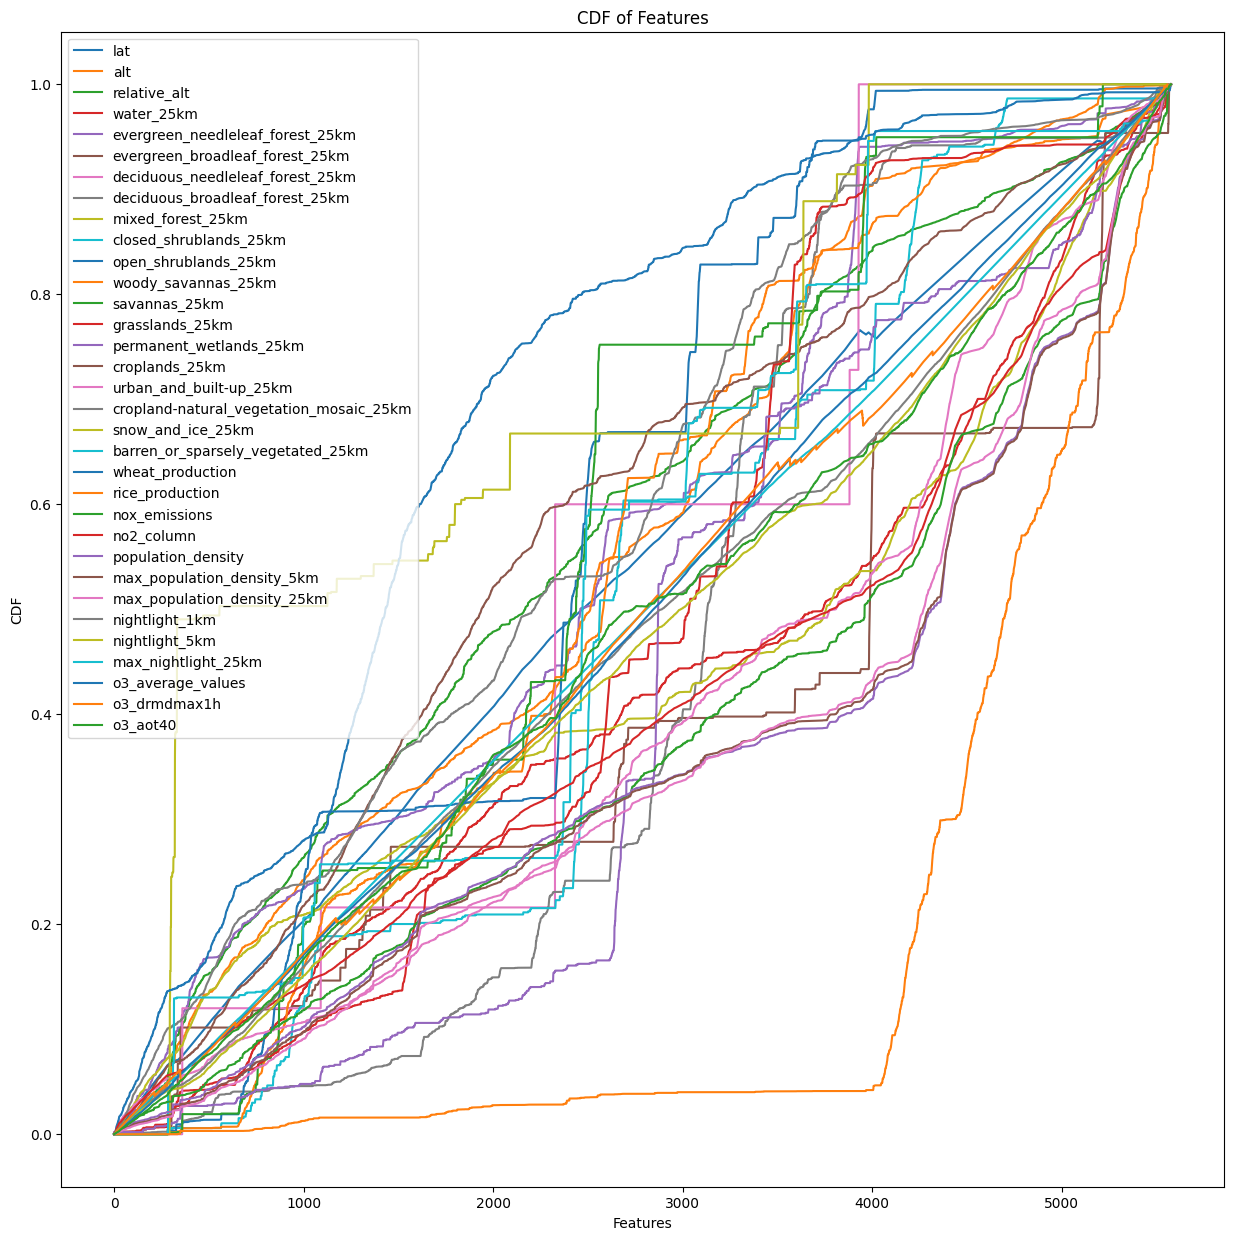

In [ ]:
# Drop columns from CDF that have negative values
if (CDF < 0).any().any():
    CDF = CDF.loc[:, ~(CDF < 0).any()]

# Figure 4: Plot the CDF figure after removing any negative values
plt.figure(figsize=(15, 15))
for col in CDF.columns:
    plt.plot(CDF.index, CDF[col], label=col)
plt.title('CDF of Features')
plt.xlabel('Features')
plt.ylabel('CDF')
plt.legend(loc='best')
plt.show()



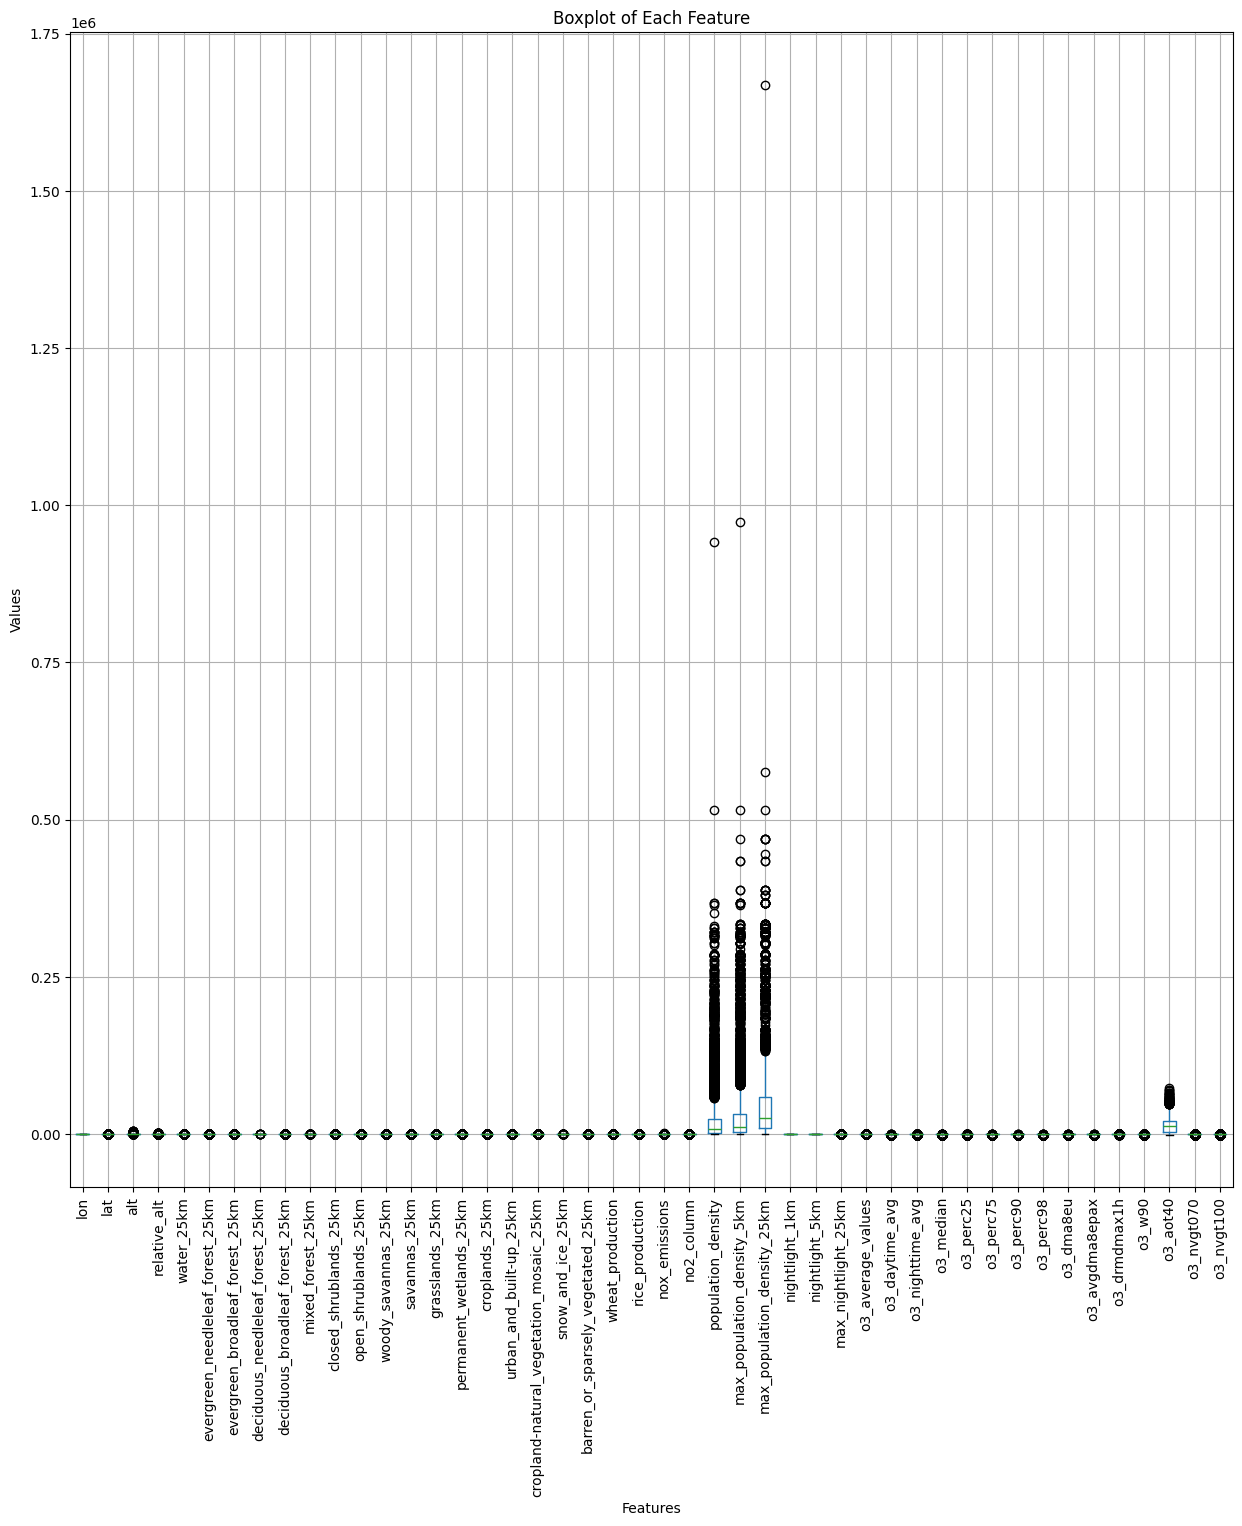

In [ ]:
# Figure 5: Boxplot of each feature for comparison of feature scale
plt.figure(figsize=(15, 15))
AQ.select_dtypes(include=['float64', 'int64']).boxplot()
plt.title('Boxplot of Each Feature')
plt.xlabel('Features')
plt.xticks(rotation=90)
plt.ylabel('Values')
plt.show()

It appears that the three largest features are related to population and all of the other featurs which are emmisions and forest cover values are not even showing up on this. Still very compressed for each of these small features. Following the EDA above I will move onto preprocessing the data. I will scale features and encode categorical features in the dataset and attempt to use them to predict one of the different target values that I have related to the ozone concentration. This is not a very large dataset it is only 5500 samples long, but it has a lot of features and runs more slowly as a result. I would not classify it as big data however. One thing I do want to try because it is running slowly is using a PCA on the scaled data to see if I can reduce the number of dimensions and I will try to test how the regression works with the lower dimensional data compared to the raw data.

# Preprocessing

In this section I will prepare the data for the machine learning models that I will apply later by preparing the data using either scaling or encoding categorical features. There are a lot of features in this data and there are also multiple target features that I could consider trying to predict. I will start by trying to predict the average ozone levels in the data which is feature 37. I will scale the data using the standard scaler so that each scaled feature has a mean of 0 and a standard deviation of 1. This will ensure that each of the features is on the same scale for target prediction after that. I will include more details related to processes before each of them is performed.

The information in the dataset column is storing what type the data is, which is either train, test of validate. This is here because the data is specifically prepared for machine learnign applications meaning that the data has undergone further pre-processing than most datasets. These splits are separated out as 60% for training, 20% for validation and 20% for testing. The raw data was clustered spatially with all data points within a 50 km area in the same cluster, and then the splits were drawn independently from each of the clusters, this ensures that spatial dependence of the data is elimiated. Therefore since the data already includes handling of autocorrelation, it will be faster computationally to use the existing splits rather than recreate this.


Since there are so many different target features in the dataset that could be predicted I will remove them from the feature dataset and separate that out into just the X features, then I will save the target variable of interest into the feature y for prediction in the models.

In [ ]:
# Separate out the target features into a target feature dataframe, then separately pull out the average ozone as the target feature of interest
X = AQ[AQ.columns[0:36]] # Leave out the id which is just an index, but inclue the remaining input variables
y = AQ['o3_average_values'] # Store the targt variable into the y value

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5577 entries, 0 to 5576
Data columns (total 36 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   country                                  5577 non-null   object 
 1   htap_region                              5577 non-null   object 
 2   climatic_zone                            5577 non-null   object 
 3   lon                                      5577 non-null   float64
 4   lat                                      5577 non-null   float64
 5   alt                                      5577 non-null   float64
 6   relative_alt                             5577 non-null   int64  
 7   type                                     5577 non-null   object 
 8   type_of_area                             5577 non-null   object 
 9   water_25km                               5577 non-null   float64
 10  evergreen_needleleaf_forest_25km         5577 no

In [ ]:
# Split the data based on the dataset feature into train, test and validation splits
X_train = X[AQ['dataset'] == 'train']
X_val = X[AQ['dataset'] == 'val']
X_test = X[AQ['dataset'] == 'test']

# Split the target features using the same method
y_train = y[AQ['dataset'] == 'train']
y_val = y[AQ['dataset'] == 'val']
y_test = y[AQ['dataset'] == 'test']

In [ ]:
# Scale the input features as for only the numeric values in the data
# I will fit the scaler using only the X_train data to prevent data leakage, and then transform the other splits
# Initialize the standard scaler
scaler = StandardScaler()

# Scale the numeric features in the training data
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train.select_dtypes(include=['float64', 'int64'])), columns=X_train.select_dtypes(include=['float64', 'int64']).columns)

# transform the other columns using the fit scaler from the training data
X_val_scaled = pd.DataFrame(scaler.transform(X_val.select_dtypes(include=['float64', 'int64'])), columns=X_val.select_dtypes(include=['float64', 'int64']).columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test.select_dtypes(include=['float64', 'int64'])), columns=X_test.select_dtypes(include=['float64', 'int64']).columns)

# View the training data to ensure integrity
X_train_scaled.head()


,lon,lat,alt,relative_alt,water_25km,evergreen_needleleaf_forest_25km,evergreen_broadleaf_forest_25km,deciduous_needleleaf_forest_25km,deciduous_broadleaf_forest_25km,mixed_forest_25km,...,wheat_production,rice_production,nox_emissions,no2_column,population_density,max_population_density_5km,max_population_density_25km,nightlight_1km,nightlight_5km,max_nightlight_25km
0,-0.025837,1.131852,-0.557349,-0.435825,2.181619,-0.181887,-0.130723,-0.027773,-0.317244,-0.488663,...,0.303766,-0.340274,-0.583689,-0.513190,-0.492922,-0.540619,-0.582069,-1.704269,-1.614415,0.016297
1,-0.099662,0.860783,-0.122059,0.151733,-0.662582,-0.111577,-0.130723,-0.027773,-0.317244,0.639005,...,0.061254,-0.340274,-0.389841,0.678521,-0.225601,-0.235936,-0.362078,0.091644,0.340545,0.243169
2,-0.090972,0.942303,-0.463463,-0.372549,-0.662582,-0.302419,-0.130723,-0.027773,-0.317244,-0.030110,...,1.210449,-0.340274,-0.499072,0.911845,-0.432211,-0.491488,-0.516615,0.091644,-0.756917,-0.210575
3,-0.089832,0.917564,-0.474132,-0.390628,-0.662582,0.310285,-0.130723,-0.027773,-0.317244,0.213205,...,-0.117318,-0.340274,0.212021,1.536553,-0.116748,-0.017352,-0.222347,0.690282,1.020363,0.356605
4,-0.084483,0.918370,-0.399450,-0.390628,-0.662582,-0.111577,-0.130723,-0.027773,-0.317244,0.213205,...,0.766324,-0.340274,0.097298,1.195347,0.011109,-0.128550,-0.222347,0.736331,0.963389,0.356605


This looks good in terms of scaling, now all of the numeric data are on the same scale, time to move onto the one-hot encoding of categorical variables.

In [ ]:
# One Hot encode the categorical variables
# Initiailize the one hot encoder
ohe = OneHotEncoder(sparse_output=False)

# One hot encode the categorical variables
X_encoded = pd.DataFrame(ohe.fit_transform(X.select_dtypes(include=['object'])), columns=ohe.get_feature_names_out())

# Split the encoded data based on the "dataset" splits column
X_train_encoded = X_encoded[AQ['dataset'] == 'train']
X_val_encoded = X_encoded[AQ['dataset'] == 'val']
X_test_encoded = X_encoded[AQ['dataset'] == 'test']

# View the training data to ensure integrity
X_train_encoded.head()

,country_Algeria,country_American Samoa,country_Antarctica,country_Argentina,country_Armenia,country_Australia,country_Austria,country_Barbados,country_Belgium,country_Bermuda,...,type_background,type_industrial,type_other,type_traffic,type_unknown,type_of_area_remote,type_of_area_rural,type_of_area_suburban,type_of_area_unknown,type_of_area_urban
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
# Finally I want to concatenate the scaled and encoded data into the same feature dataset for processing for each split
# I had to reset the index because when they were concatenating they were introducing thousands of NaN values, this solves that
X_train = pd.concat([X_train_scaled.reset_index(drop=True), X_train_encoded.reset_index(drop=True)], axis=1)
X_val = pd.concat([X_val_scaled.reset_index(drop=True), X_val_encoded.reset_index(drop=True)], axis=1)
X_test = pd.concat([X_test_scaled.reset_index(drop=True), X_test_encoded.reset_index(drop=True)], axis=1)


X_train.head()

,lon,lat,alt,relative_alt,water_25km,evergreen_needleleaf_forest_25km,evergreen_broadleaf_forest_25km,deciduous_needleleaf_forest_25km,deciduous_broadleaf_forest_25km,mixed_forest_25km,...,type_background,type_industrial,type_other,type_traffic,type_unknown,type_of_area_remote,type_of_area_rural,type_of_area_suburban,type_of_area_unknown,type_of_area_urban
0,-0.025837,1.131852,-0.557349,-0.435825,2.181619,-0.181887,-0.130723,-0.027773,-0.317244,-0.488663,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.099662,0.860783,-0.122059,0.151733,-0.662582,-0.111577,-0.130723,-0.027773,-0.317244,0.639005,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.090972,0.942303,-0.463463,-0.372549,-0.662582,-0.302419,-0.130723,-0.027773,-0.317244,-0.030110,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-0.089832,0.917564,-0.474132,-0.390628,-0.662582,0.310285,-0.130723,-0.027773,-0.317244,0.213205,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.084483,0.918370,-0.399450,-0.390628,-0.662582,-0.111577,-0.130723,-0.027773,-0.317244,0.213205,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
# Check for missing values in the training data
X_train.isnull().sum()

,0
lon,0
lat,0
alt,0
relative_alt,0
water_25km,0
...,...
type_of_area_remote,0
type_of_area_rural,0
type_of_area_suburban,0
type_of_area_unknown,0


Ok this looks great! All of the numeric variables have been scaled using the standard scaler and the categorical variables have been encoded using the one-hot encoder. I already split the data before scaling and encoding the data to prevent model leakage using spatailly dependent splits that account for autocorrelation, so the data is ready for model evaluation. The last thing I want to do here is to reduce the dimensions of the data using PCA to account for 90% of the variability in the data with fewer features, and I will compare two of the three machine learning models I will run below with the raw data and the reduced dimensionality data.

In [ ]:
# Use PCA to reduce the dimensionality of the X_train features to account for 90% of the variability with fewer features
pca = PCA(n_components=0.9, svd_solver='full', random_state=23435)
X_pca = pca.fit_transform(X_train)

# Create DataFrame with transformed data and component names as columns
X_pca = pd.DataFrame(data=X_pca, columns=[f'Component{i}' for i in range(1, pca.n_components_ + 1)])


# Look at the PCA data and assess the number of components that were kept as well as evaluate the total variance accounted for
print(f'Number of components kept: {pca.n_components_}')
print(f'Total variance accounted for: {pca.explained_variance_ratio_.sum()}')

X_pca.head()

Number of components kept: 23
Total variance accounted for: 0.9094607361300188


,Component1,Component2,Component3,Component4,Component5,Component6,Component7,Component8,Component9,Component10,...,Component14,Component15,Component16,Component17,Component18,Component19,Component20,Component21,Component22,Component23
0,-1.905497,-0.981580,0.716660,0.036987,-0.061076,0.725823,0.656165,-1.268445,2.108351,-0.475140,...,1.001017,0.589112,-0.012398,0.012117,0.794235,0.262914,-0.138609,-0.196197,-0.205086,1.008964
1,-0.277930,-0.990632,-0.768873,-1.166646,0.274458,-0.206594,0.158752,0.035176,0.132107,0.911908,...,-0.006621,0.004926,0.918325,-0.364244,0.610437,0.138302,-0.339844,-0.542415,-0.110745,-0.328957
2,-1.126975,-1.671769,-1.394085,-1.328181,0.635199,0.685672,0.144274,0.300263,0.489918,0.298323,...,0.203067,-0.482152,0.966170,-0.605958,1.282993,0.419845,0.092614,-1.702748,0.258148,-0.121741
3,1.466182,-0.424653,-1.118186,-0.799407,0.307053,-0.722768,0.360923,-0.453474,0.214837,0.800181,...,-0.254086,-0.449104,0.744178,-0.101718,0.047293,-0.350417,0.234580,-0.702828,-0.108961,-0.771827
4,1.149571,-1.019238,-1.492196,-0.822862,-0.239222,-0.256551,0.266652,-0.328347,0.198852,0.700753,...,-0.082225,-0.228842,0.785038,-0.102912,-0.081410,-0.464354,0.094277,-0.644302,0.331883,-0.641753


Ok so we kept 23 components which account for ~91% of the variance in the data. I am curious to see how this will compare the the models fit with the raw data. This will be somewhat experimental for me in determine the impact of this process on fitting a model. One thing I want to do first is to take a look at the PCA first to see what features vary in terms of the first two principal components.

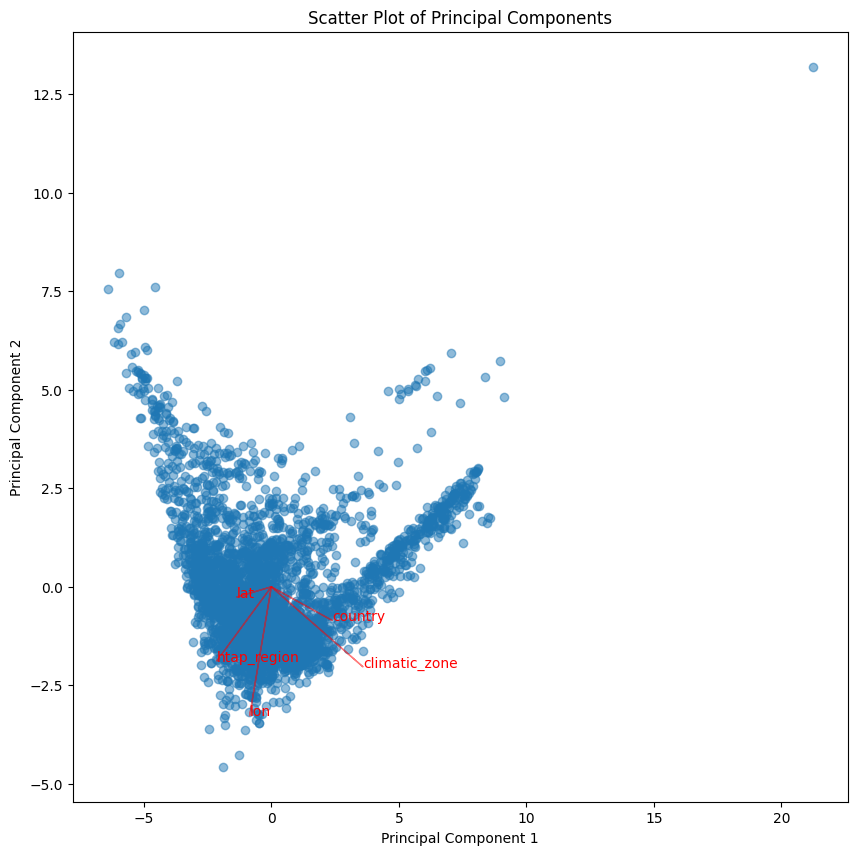

In [ ]:
# Figure 6: Plot the original data in terms of the first two principal components and plot eigenvectors for the top five features
plt.figure(figsize=(10, 10))
plt.scatter(X_pca.iloc[:, 0], X_pca.iloc[:, 1], alpha=0.5)
for i in range(5):
    plt.arrow(0, 0, pca.components_[i, 0]*10, pca.components_[i, 1]*10, color='r', alpha=0.5)
    plt.text(pca.components_[i, 0]*10, pca.components_[i, 1]*10, X.columns[i], color='r')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatter Plot of Principal Components')
plt.show()

This shows me that the first principal component depends on the country where the observations are from as well as the climatic zone. I assume that the country has to do with features related to industrialization and this makes sense because a more industrialized country will have more emmissions that can lead to ozone formation. Additionally the climatic zone also matters which may make sense because in different climate types the weather may impact ozone formation as well as the type of regional biology that exists. The second principal component is affected heavily by the longitude of the sample and the htap region.

Text(0, 0.5, 'Cumulative Explained Variance')

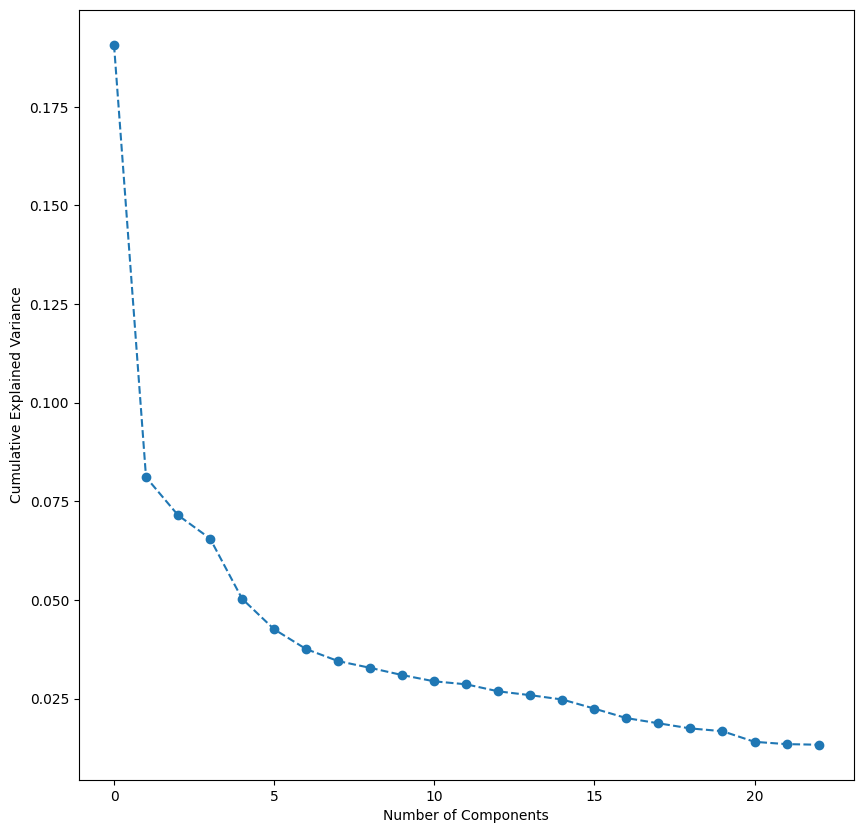

In [ ]:
# Figure 7: Plot the variance explained vs the princiapl component for each of the components I kept
plt.figure(figsize=(10, 10))
plt.plot(pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')


In [ ]:
# Transform the other feature splits for the data
X_train_pca = X_pca
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

# Model Fitting

## Linear Regression
I am going to start with linear regression because it is fast, simple to understand and visualize and can provide a good baseline for the other models I want to try.

In [ ]:
# Start by fitting the linear regression model to the raw input features
# Initialize the model using fit intercept false as a hyperparamter because I already scaled the data so the intercept will be zero
lr = LinearRegression(fit_intercept=False)

lr.fit(X_train, y_train)

# Predict the output data
y_pred = lr.predict(X_test)

In [ ]:
# Evaluate the model
print(f'Mean Squared Error: {mean_squared_error(y_test, y_pred)}')
print(f'Root Mean Squared Error: {root_mean_squared_error(y_test, y_pred)}')
print(f'Mean Absolute Error: {mean_absolute_error(y_test, y_pred)}')
print(f'R2 Score: {r2_score(y_test, y_pred)}')

Mean Squared Error: 20.136714351329235
Root Mean Squared Error: 4.487395051845696
Mean Absolute Error: 3.2507876550485353
R2 Score: 0.5228317465913803


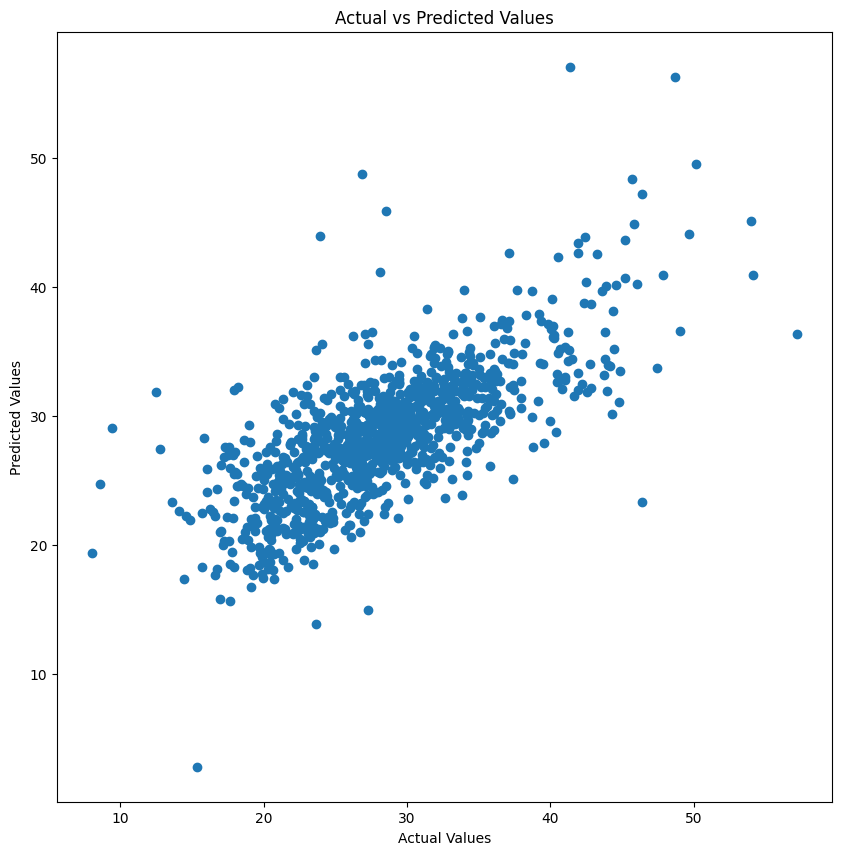

In [ ]:
# Figure 8: Plot of the input vs predicted values from the raw data
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

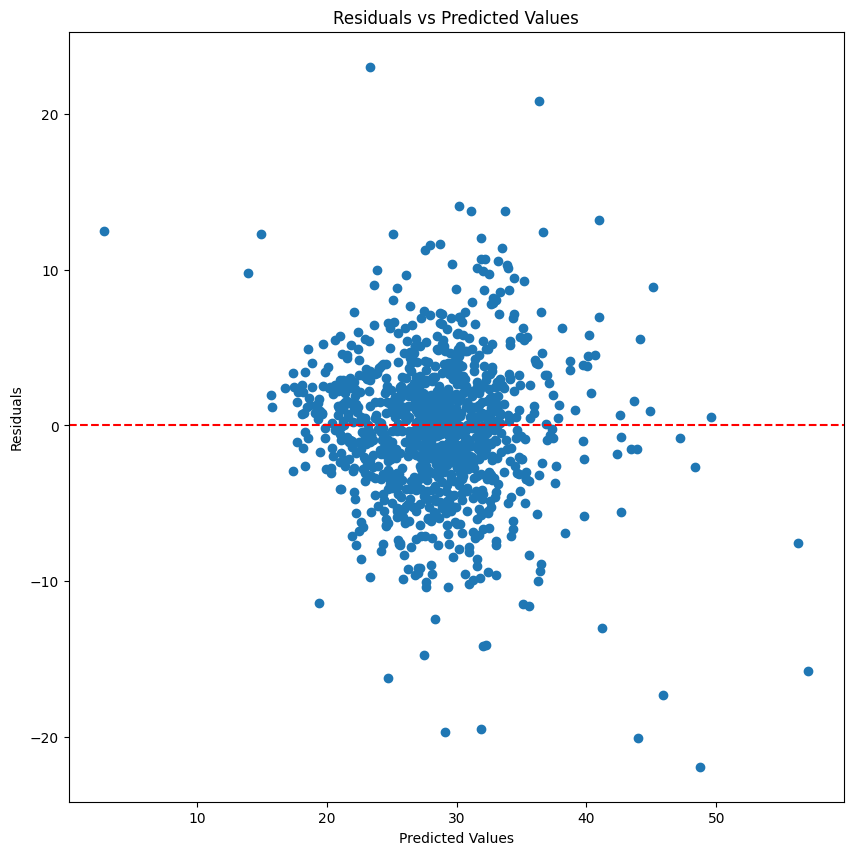

In [ ]:
# Figure 9: Plot of residuals for the initial linear regression fit
residuals = y_test - y_pred
plt.figure(figsize=(10, 10))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()

This model fits the data fiarly well but not perfectly. There is a slight difference in the MAE and RMSE which indicates that since the RMSE is about 1.25 ppb higher than the MAE there are some large outliers which are overall affecting the data. The model does not fit the data perfectly however the R-squared is about 52 which suggests that the model accounts for about 52% of the variance in the output data. Overall the MAE is only 3.25 ppb meaning that we can do a fairly good job most of the time of predicting what the average ozone concentariton for a region will be. This model is not perfect but it is pretty good. One thing that I will point out is that it performs worse than the original draft but that is likely due to resolved issues with data leakage that caused the model to predict the average ozone almost perfectly.

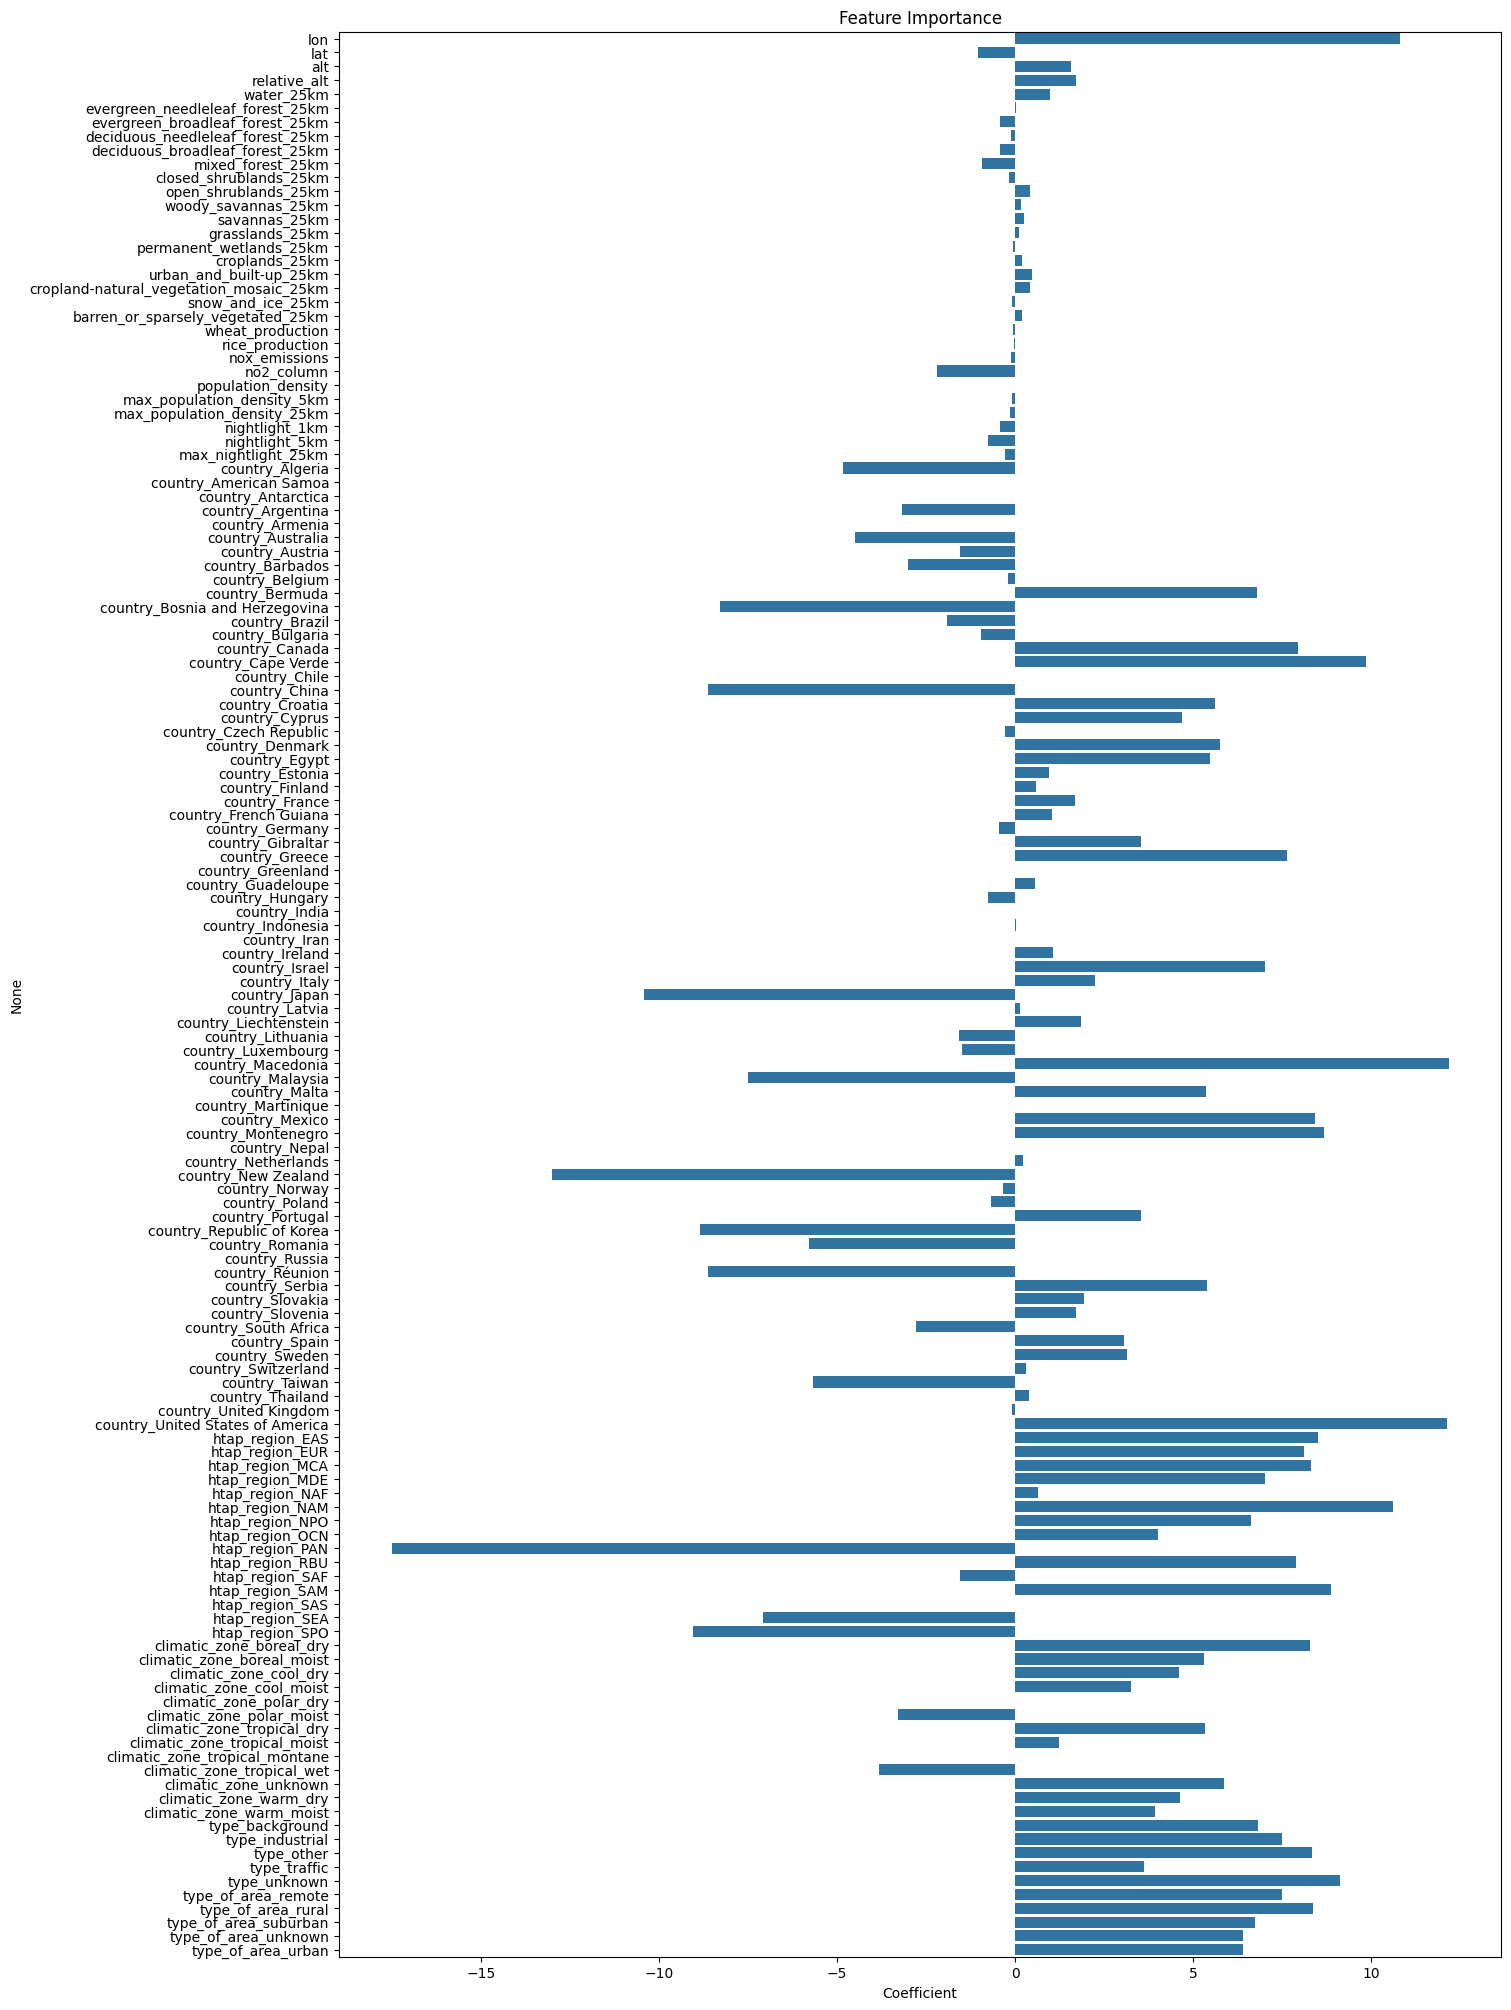

In [ ]:
# Plot the feature importance for predicting average ozone
plt.figure(figsize=(15, 25))
sns.barplot(x=lr.coef_, y=X_test.columns)
plt.title('Feature Importance')
plt.xlabel('Coefficient')
plt.show()

The above shows the feature importance for predictions of the simple linear model. Some of the most important prediction features appear to be the "type of area" encoded values in the positive direction and the htap region (hemispheric transport of air polutants) suggesting that specific htap regions have higher ozone than others, the one with a very negative coefficient was the PAN region which is the Pacific, Australia and New Zealand.

In [ ]:
# Fit the linear model with the PCA data instead of the raw data to compare them
lr_pca = LinearRegression(fit_intercept=True)
lr_pca.fit(X_train_pca, y_train)

# Predict the output data
y_pred_pca = lr_pca.predict(X_test_pca)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Mean Squared Error: 22.422922474963425
Root Mean Squared Error: 4.735284835673925
Mean Absolute Error: 3.629717375518191
R2 Score: 0.4686567745353698


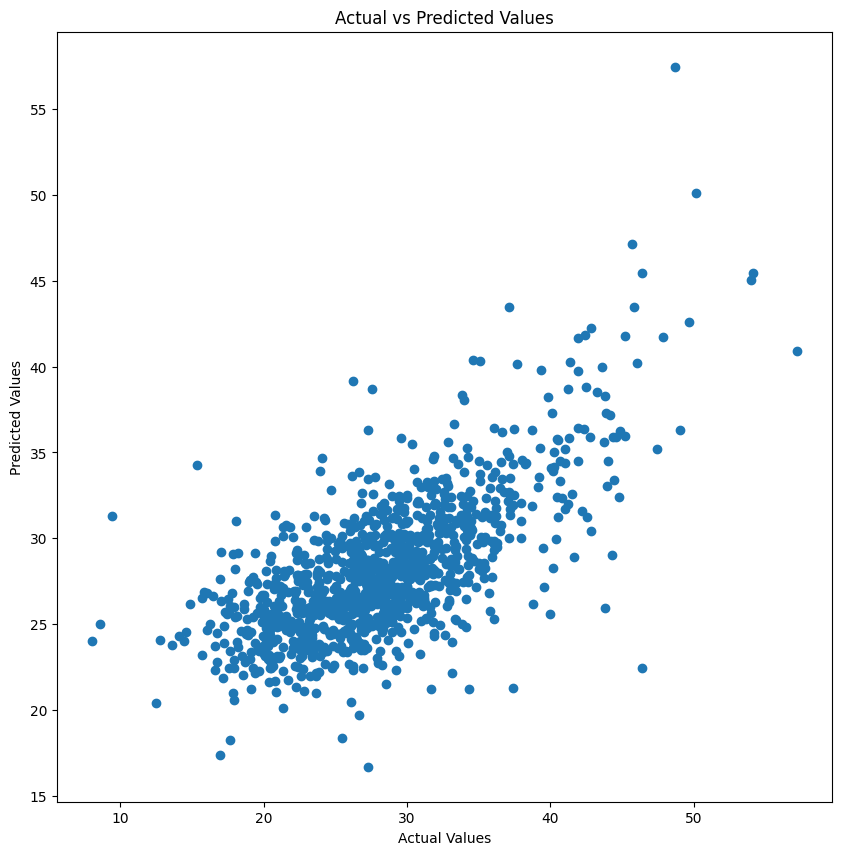

In [ ]:
# Evaluate the model
print(f'Mean Squared Error: {mean_squared_error(y_test, y_pred_pca)}')
print(f'Root Mean Squared Error: {root_mean_squared_error(y_test, y_pred_pca)}')
print(f'Mean Absolute Error: {mean_absolute_error(y_test, y_pred_pca)}')
print(f'R2 Score: {r2_score(y_test, y_pred_pca)}')

# Figure 9: Plot of the actual vs predicted values fir to the model using the PCA output
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred_pca)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

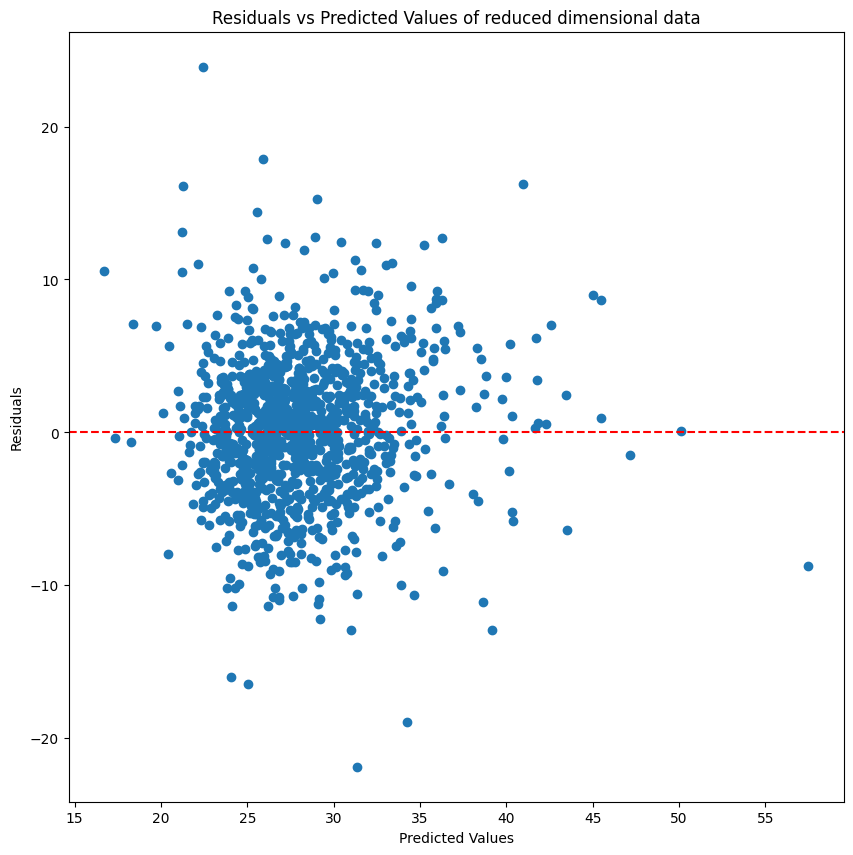

In [ ]:
# Figure 10: Residual plot for the PCA fit data to evaluate for any trends
residuals = y_test - y_pred_pca
plt.figure(figsize=(10, 10))
plt.scatter(y_pred_pca, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values of reduced dimensional data')
plt.show()

Overall the linear regression is a really simple model to understand what is happening, and it is fairly easy to evaluate using just a comparison of the predicted vs the fit values as a scatter plot. I like that for the regression type problems. The data values were predicted okay with a RMSE of ~22 ppb which is okay considering the range of actual values is nearly 60 ppb. The R-squared is close to 0.5 suggesting that the model performs okay but not great. When I compare this model to the PCA fit data for a test of how reducing the dimensionality of a large (over 100 feature) dataset performs I notice that it performs slightly worse with a slightly lower R-squared and a slightly higher error for the three error statistics. Hwoever the difference between the raw and pca data is negligible and not any faster suggesting that the reduced dimensional data performs almost as well as the raw data and doe not provide any benefit in this situation.

## Decision Tree Regressor

I really wanted to try the decision tree regressor to see how well it performs. I am going to perform hyperparameter tuning in this example also.

In [ ]:
# Fit the decision tree regressor to the training data
# Initialize the model
dt = DecisionTreeRegressor()

# Fit the model to the training data
dt.fit(X_train, y_train)

# Predictthe validation data
y_val_pred = dt.predict(X_val)

# Evaluate the initial model run
print(f'Mean Squared Error: {mean_squared_error(y_val, y_val_pred)}')
print(f'Root Mean Squared Error: {root_mean_squared_error(y_val, y_val_pred)}')
print(f'Mean Absolute Error: {mean_absolute_error(y_val, y_val_pred)}')
print(f'R2 Score: {r2_score(y_val, y_val_pred)}')

Mean Squared Error: 32.28160852641832
Root Mean Squared Error: 5.68169063980241
Mean Absolute Error: 4.180304398563734
R2 Score: 0.16620779924258


This is not a very good model fit to begin with the error is extremely high close 4 (MAE) with an MSE of 32 and an R-squared value near zero suggesting that major improvements in the model hyperparameters are needed in order to fit the model better. I am hoping that the fit will improve up to the success of the linear model.

In [ ]:
# Fit the decision tree regressor to the reduced dimensional training data
# Initialize the model
dt_pca = DecisionTreeRegressor()

# Fit the model to the training data
dt_pca.fit(X_train_pca, y_train)

# Predict the validation to perform hyperparameter tuning, but we need a baseline model here
y_val_pred_pca = dt_pca.predict(X_val_pca)

# Evaluate the initial model run
print(f'Mean Squared Error: {mean_squared_error(y_val, y_val_pred_pca)}')
print(f'Root Mean Squared Error: {root_mean_squared_error(y_val, y_val_pred_pca)}')
print(f'Mean Absolute Error: {mean_absolute_error(y_val, y_val_pred_pca)}')
print(f'R2 Score: {r2_score(y_val, y_val_pred_pca)}')

Mean Squared Error: 35.266875376633756
Root Mean Squared Error: 5.93859203655494
Mean Absolute Error: 4.528763644524237
R2 Score: 0.08910221713218713


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


Overall this model performs terribly as well lets try to improve them using hyperparameter tuning. I will use both GridSearchCV and RandomizedSearchCV to find the optimal parameters that fit the model better. I am hoping to make the model run as well as the linear regression model. I will compare the two output sets of parameters from the two hyperparameter tuning methods to determine which fit teh validation data better then evaluate the final model based on the testing data. Note that this step takes around 10-12 minutes to run.

In [ ]:
# Perform hyperparameter tuniing
# Perform hyperparameter tuning using the GridSearch method
parameters = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
              'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']}

dt = DecisionTreeRegressor()
grid_search = GridSearchCV(dt, parameters)
grid_search.fit(X_train_pca, y_train)
print(f'Best parameters using Grid Search: {grid_search.best_params_}')

# Perform hyperparameter tuning using the RandomizedSearch method
random_search = RandomizedSearchCV(dt, parameters)
random_search.fit(X_train_pca, y_train)
print(f'Best parameters using Random Search: {random_search.best_params_}')

Best parameters using Grid Search: {'criterion': 'absolute_error', 'max_depth': 5, 'min_samples_split': 10}
Best parameters using Random Search: {'min_samples_split': 5, 'max_depth': 5, 'criterion': 'absolute_error'}


The two different methods resulted in a different result for the optimal parameters, I will evaluate both of them using the vaildation data to determine which of the parameter combinations works better so that I can determine the optimal parameter space.

In [ ]:
# Test the model using the two different combinations of parameters to determine which generates a better fit to unseen data
# Try the Grid Search method
dt_GS = DecisionTreeRegressor(max_depth=5, min_samples_split=10, criterion='absolute_error')
dt_GS.fit(X_train_pca, y_train)
y_val_GS = dt_GS.predict(X_val_pca)

# Evaluate the model
print(f'Mean Squared Error (Grid Search): {mean_squared_error(y_val, y_val_GS)}')
print(f'Root Mean Squared Error (Grid Search): {root_mean_squared_error(y_val, y_val_GS)}')
print(f'Mean Absolute Error (Grid Search): {mean_absolute_error(y_val, y_val_GS)}')
print(f'R2 Score (Grid Search): {r2_score(y_val, y_val_GS)}')
print()


# Try the Randomized Search
dt_RS = DecisionTreeRegressor(max_depth=5, min_samples_split=5, criterion='absolute_error')
dt_RS.fit(X_train_pca, y_train)
y_val_RS = dt_RS.predict(X_val_pca)

# Evaluate the model
print(f'Mean Squared Error (Random Search): {mean_squared_error(y_val, y_val_RS)}')
print(f'Root Mean Squared Error (Random Search): {root_mean_squared_error(y_val, y_val_RS)}')
print(f'Mean Absolute Error (Random Search): {mean_absolute_error(y_val, y_val_RS)}')
print(f'R2 Score (Random Search): {r2_score(y_val, y_val_RS)}')


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


Mean Squared Error (Grid Search): 25.372917462378815
Root Mean Squared Error (Grid Search): 5.037153706447602
Mean Absolute Error (Grid Search): 3.7168682226211858
R2 Score (Grid Search): 0.3446503549140071

Mean Squared Error (Random Search): 25.475774868195693
Root Mean Squared Error (Random Search): 5.047353253755446
Mean Absolute Error (Random Search): 3.7253953321364452
R2 Score (Random Search): 0.3419936811398342


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


According to this evaluation of the two different methods of hyperparameter tuning the results of the Grid Search resulted in a slightly higher scoring model than the Randomized Search method did, however in reality the two are within only a small fraction of the two and therefore they can be considered identical fits. However these do both perform significantly better than the original model fit using default parameters, however not quite as good as the linear regression model.

In [ ]:
# Test the model using the best fitting hyperparameters
dt_best = DecisionTreeRegressor(max_depth=5, min_samples_split=10, criterion='absolute_error')
dt_best.fit(X_train_pca, y_train)
y_test_pred = dt_best.predict(X_test_pca)

# Evaluate the model
print(f'Mean Squared Error: {mean_squared_error(y_test, y_test_pred)}')
print(f'Root Mean Squared Error: {root_mean_squared_error(y_test, y_test_pred)}')
print(f'Mean Absolute Error: {mean_absolute_error(y_test, y_test_pred)}')
print(f'R2 Score: {r2_score(y_test, y_test_pred)}')


Mean Squared Error: 28.855744354071753
Root Mean Squared Error: 5.371754308796313
Mean Absolute Error: 4.136994529147982
R2 Score: 0.3162218575480187


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


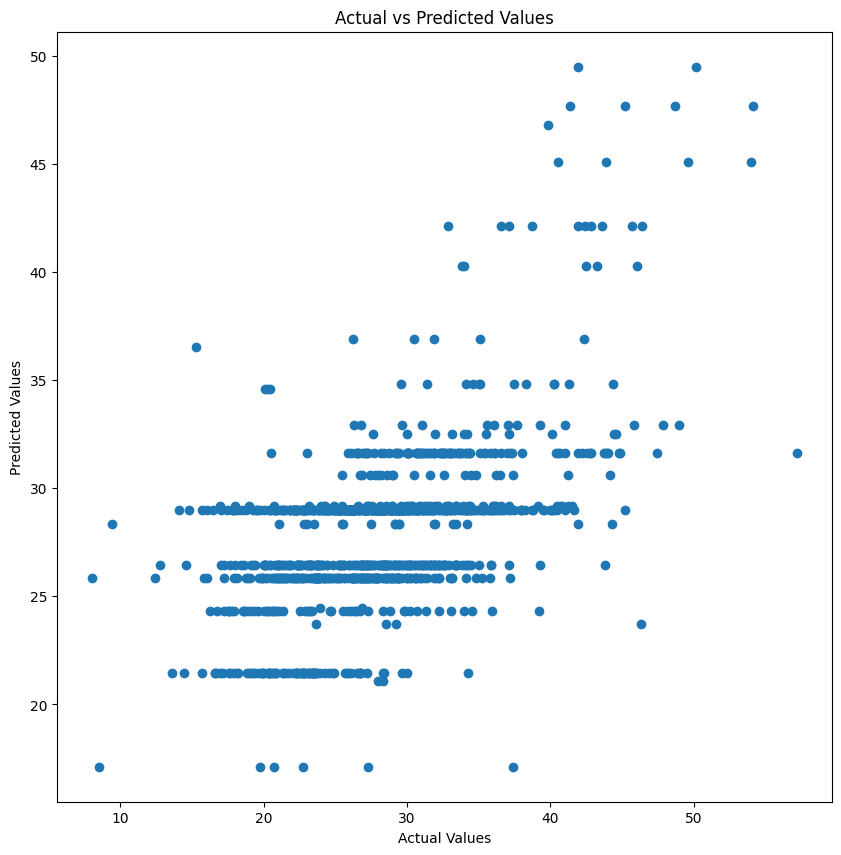

In [ ]:
# Plot the actual versus the predicted values
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_test_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()


It is pretty clear why this model is likely not as good as the linear regression model form before, there are clearly predictions in specific categories which result in the relationship seen in the plot above. I will say though that the model improves with the hyperparameter tuning that I performed. Overall this model did not perform as well as the linear regression model, which may be because it is not able to smoothly predict the results and instead has to split them into specific bins.

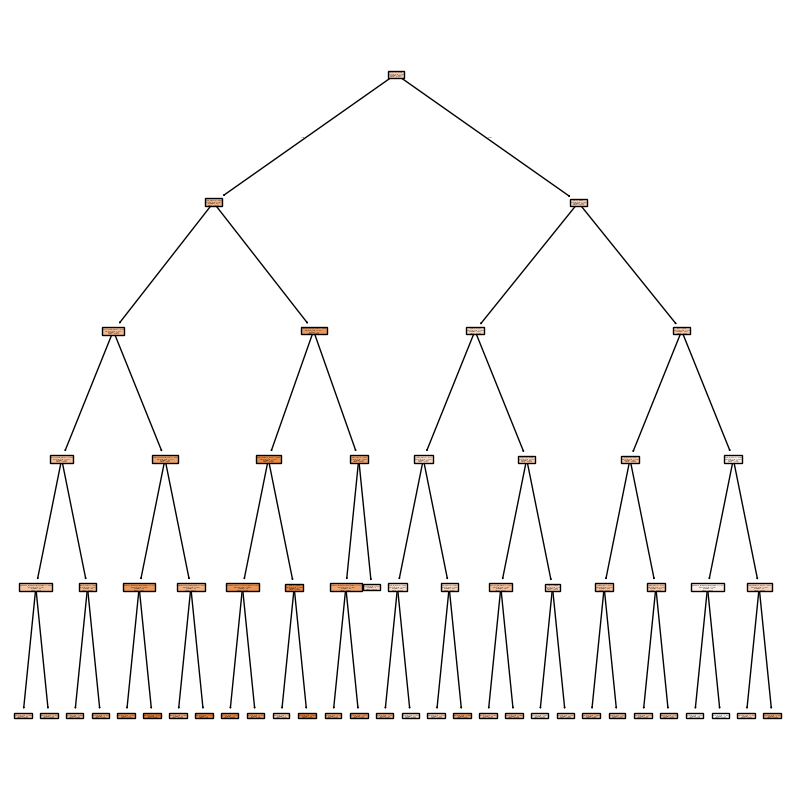

In [ ]:
# Plot the decision tree for the best model
plt.figure(figsize=(10, 10))
plot_tree(dt_best, filled=True, feature_names=X.columns)
plt.show()

Above is the tree that is plotted from the best fit model, it is not too deep and is optimized, so although the error is higher than for the linear model and it has a loter R-squared, it is the best that it could be based on the training that I did.

## Neural Network

For the last model I have decided to try using an Artificial Neural Network to estimate the average ozone. I anticipate that this will probably work fairly well and certainly better than the decision tree. I will also only run this using the raw data (not the pca data like I ahave been) because I know it will take a little while so I don't want it to take too long

In [ ]:
# Model Initialization
# The first step with a neural network is to define the shape of the input data which will be needed to define the initial number of neurons
input_shape = X_train.shape[1:]

# Initialize the model, I will use the ReLU function as the activation function for the hidden layers and use 3 hidden layers
# since this is a regression problem I will use the linear function as the activation function for the output layer
model = Sequential()
model.add(Dense(64, input_shape=input_shape, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile the model using the adam optimizer and mean_squared_error as the loss function. I will monitor the MSE as the model progresses
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Fit the model using 100 epochs and a batch size of 32
%%time
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 659.5588 - mean_squared_error: 659.5588 - val_loss: 37.9545 - val_mean_squared_error: 37.9545
Epoch 2/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 26.1616 - mean_squared_error: 26.1616 - val_loss: 24.8421 - val_mean_squared_error: 24.8421
Epoch 3/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 18.4370 - mean_squared_error: 18.4370 - val_loss: 21.2722 - val_mean_squared_error: 21.2722
Epoch 4/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 15.7624 - mean_squared_error: 15.7624 - val_loss: 20.0043 - val_mean_squared_error: 20.0043
Epoch 5/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 13.5946 - mean_squared_error: 13.5946 - val_loss: 18.7193 - val_mean_squared_error: 18.7193
Epoch 6/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 12.6745 - mean_squared_error: 12.6745 - val_loss: 18.3198 - val_mean_squared_error: 18.3198
Epoch 7/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 11.9083 - mean_squ

I'm impressed by how quickly that ran, I have watched ANN models take 35 minutes before running on only my CPU, this is fairly impressive. The final loss fluctuates around 4.3 with a mean square error of only 4.2 which is already significantly better than the other models which had an MSE of ~22 (Linear Regression) and >30 (Decision Tree Regressor).

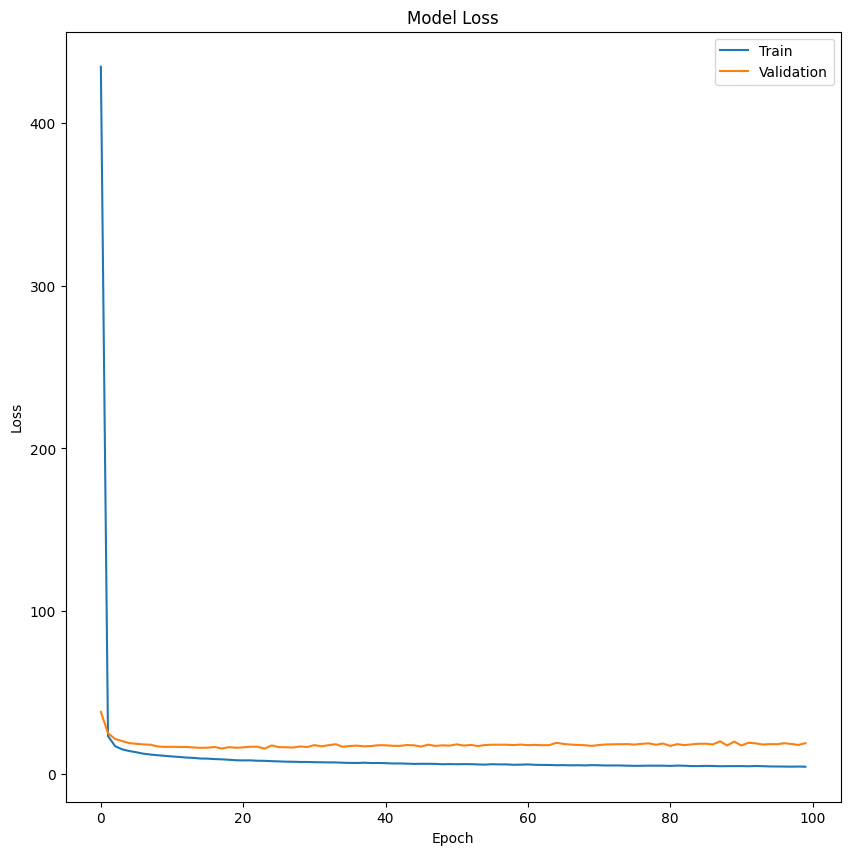

In [ ]:
# Plot the evaluation statistic for each epoch
plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
# Evaluate the model numerically
y_pred = model.predict(X_test)
print(f'Mean Squared Error: {mean_squared_error(y_test, y_pred)}')
print(f'Root Mean Squared Error: {root_mean_squared_error(y_test, y_pred)}')
print(f'Mean Absolute Error: {mean_absolute_error(y_test, y_pred)}')
print(f'R2 Score: {r2_score(y_test, y_pred)}')

test_loss, test_mse = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test MSE: {test_mse}')

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Mean Squared Error: 19.162966091271763
Root Mean Squared Error: 4.377552522959806
Mean Absolute Error: 3.320024172632876
R2 Score: 0.545906104622418
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 18.6024 - mean_squared_error: 18.6024
Test Loss: 19.1629638671875
Test MSE: 19.1629638671875


The ANN model performs slightly better than the linear regression model with a loss around 19 and a Mean Absolute Error of 3.3 ppb.

Text(0.5, 0, 'Weight')

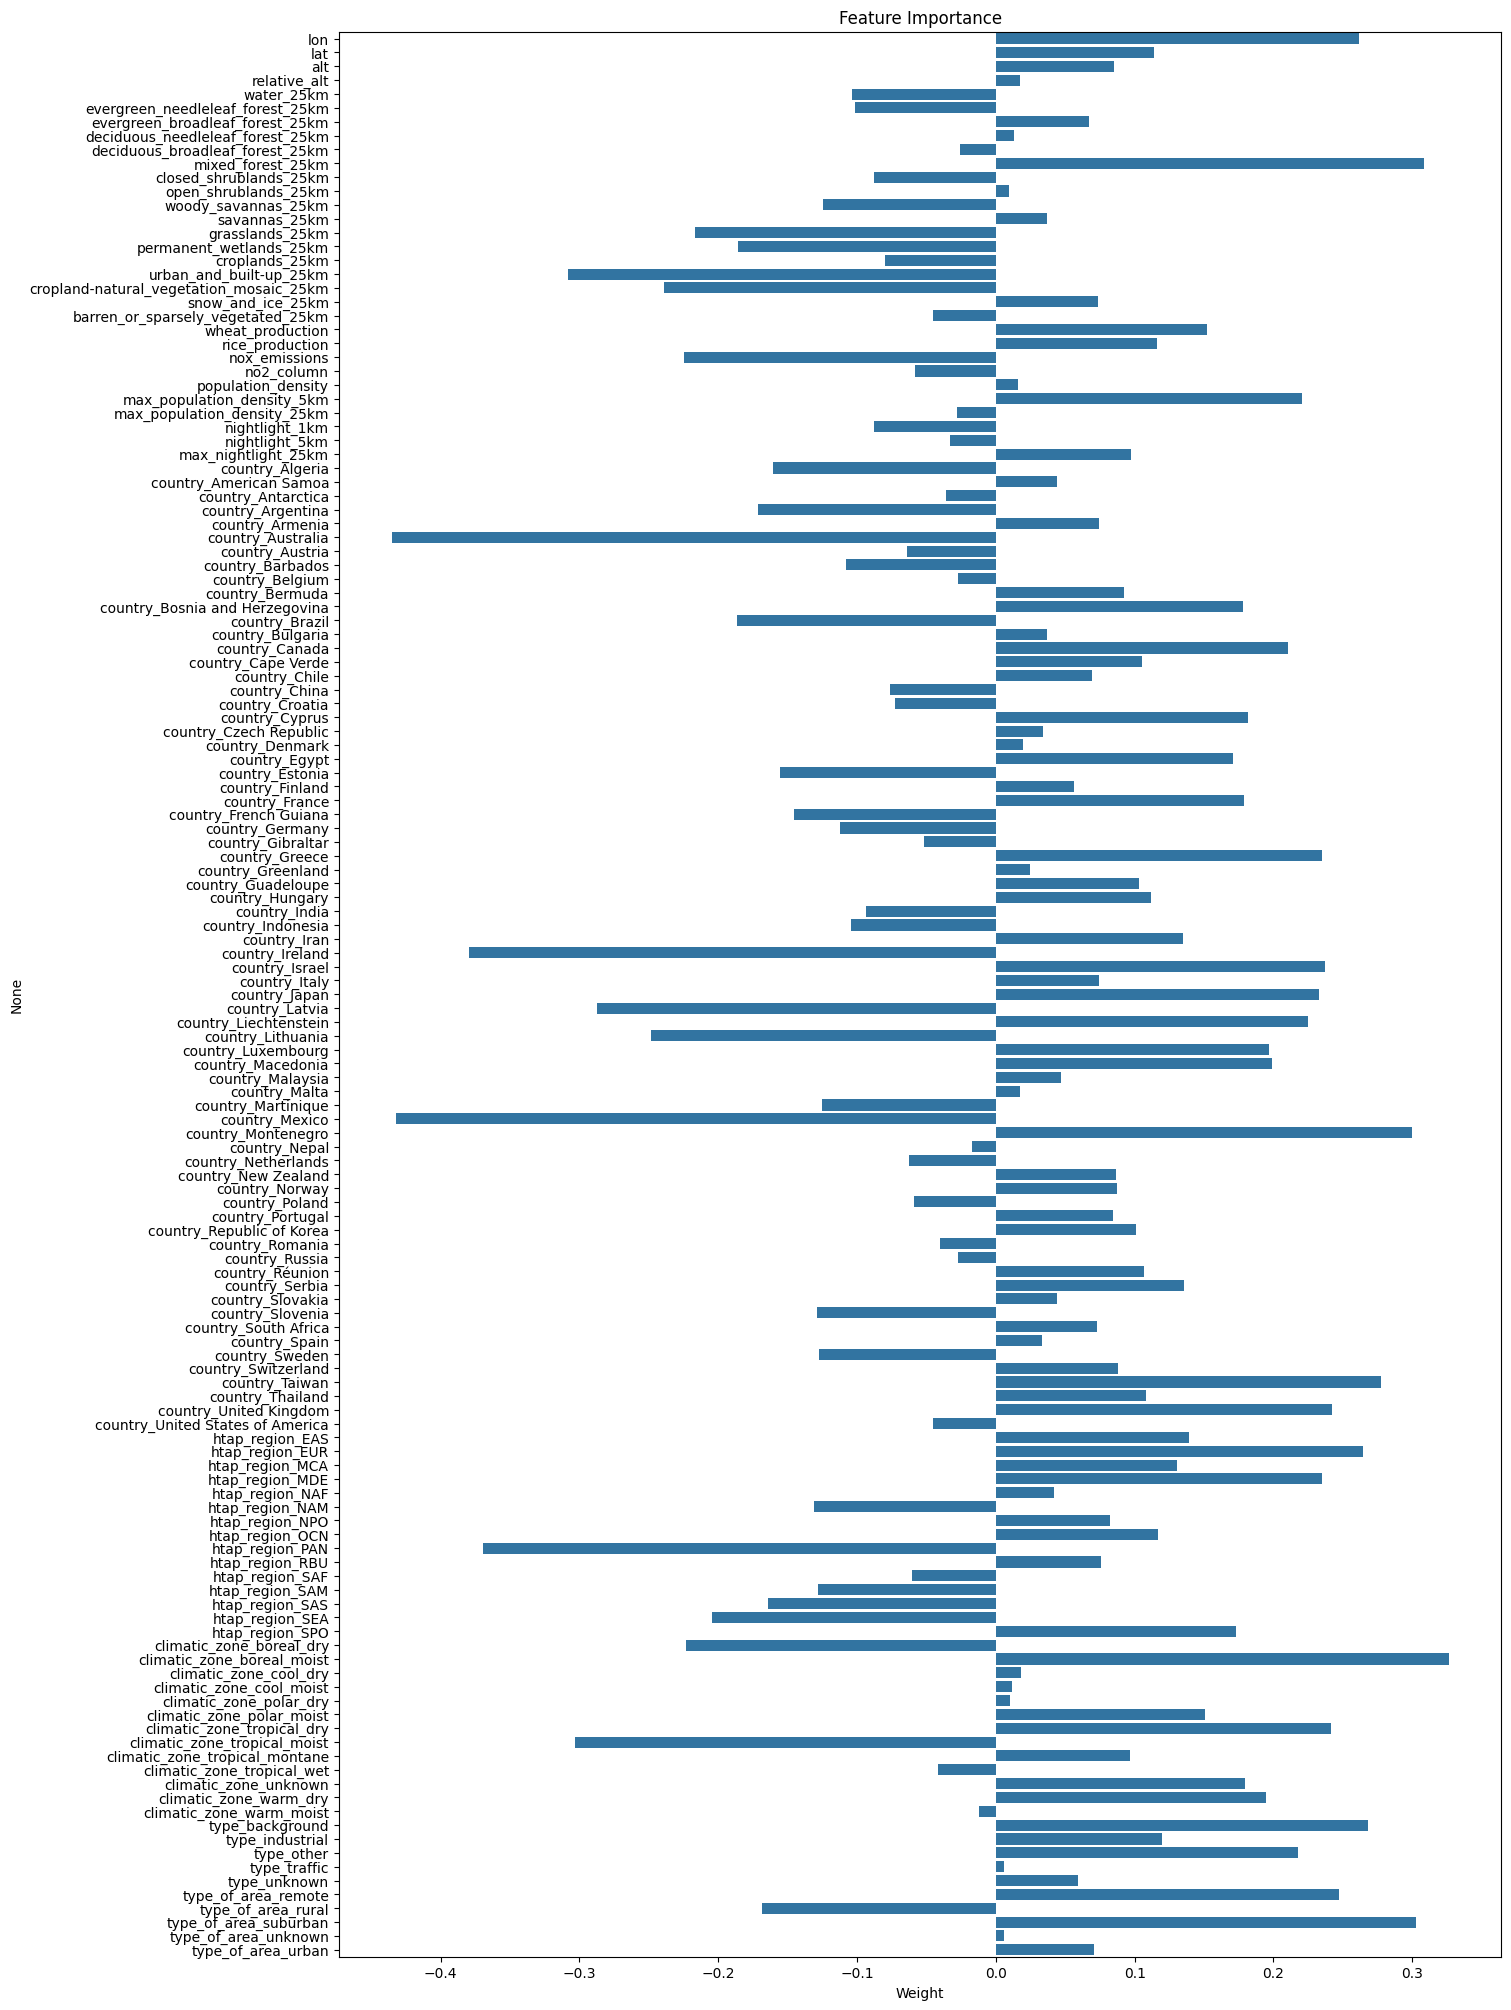

In [ ]:
# Plot the feature importance for each feature in the dataset
plt.figure(figsize=(15, 25))
sns.barplot(x=model.get_weights()[0].T[0], y=X_test.columns)
plt.title('Feature Importance')
plt.xlabel('Weight')


The plot above shows the feature importance for each feature in the dataset where the highest importance features appear to be the climatic zone that the loaction is in, where unknown and tropical wet appear to be some of the most important for predicting the output particulalry increasing it. The country also appears to have a high weight for predicting lower outcomes. in some certain circumstances. The feature importances are different from the linear regression feature importance values.

# Question Answers

### Which method did you like most?

I liked the linear regression method the most because it is extremely fast, simple to understand and resulted in the best fit for the data of the three methods that I tested. The errors in the prediction of average ozone were the lowest for the linear model and since it is so easily understood i liked it for that reason. Additionally, I think I am slightly biased because I also know the most abot linear modelling so I had previously liked this model.


### Which method did you like the least

I didn't like the decision tree model that much because it did a poor job of predicting the continous output data since it is still splitting the data into specific bins resulting in it not being able to predict the data very effectively for this type of data. I liked it a lot for classification but for continuous data it performs significantly worse. It is still easy to understand the output it just does not do a very good job on this type of data. It had by far the highest error and the worse r-squared value of all of the different models.

### How did you score these supervised models?

I scored these models using 4 measures. I used three different error measures, the mean squared error, the root mean squared error, and the mean absolute error. The mean squared error penalizes larger errors more due to scaling but is sensative to outliers, it is also harder to interpret because it is not in the same unit as the target data. The root mean squared error is the square root of the MSE so it is in the same units as the target making it easier to interpret compared to the MSE while still being sensitive to larger errors. The MAE is the absolute error so it is less sensitive to large errors and is easier to interpret. I calcualted all three of these for each model, but chose to only interpret the MAE and RMSE because of interpretability for the models. Additionally, I calculated the R-squared for each model which is a common measure of linear fit which describes the percentage of variability predicted by the model. I like this because it is well known, but since it is not always a good estimate I chose not to only calculate the R-squared value.

### Did the output align with your geologic understanding?

Yes this alligned with my geologic understanding, the region that was used in the prediction was very important and this makes sense because different countries have different emissions levels and this impacts ozone formation significantly. Mixed forests also were a strong predictor in the neural network model I ran which relates to the ability of different tree species to absorb tropospheric ozone into their stomata. Mixed forests particularly had a high positive relationship to ozone concentration which is related additionally to their high contribution of volatile organic compounds to the atmosphere which contribute to ozone. All of these known features were accurately predicted by the model. There are many other features that were indicated by the feature importance that I do not discuss here but overall they do agree with my geologic predictions for this dataset.

### What did you want to learn more about?

I want to learn more about how to understand and interpret large datasets with hundreds or thousands of features like this. I think that through this class I have gained a fairly good understanding of the steps in doing data analysis, from EDA to preprocessing to model fitting and evaluation I am feeling really good about how to do a lot of these things. What I am not certain about is how to effectively tell the story that the model is representing when there are so many features. When there are this many features it is difficult to understand which features are important, and what effect everything has on the data. I think that the output that I got from the Neural network was pretty helpful but I still am a little uncertain of how to interpret that data.

### Did you preprocess your data?

Yes I did preprocess my data, I scaled the features that were numeric and one-hot encoded the rest of them which allowed them to be on the same scale for the modelling that I did. I used pre-generated splits on the data that were generated by clustering the data spatailly to split the data into the different categories. I think that for the most part all models require preprocessing. But the degree to which this is necessary depends on the model itself. For example a decision tree can split the data using different scales because of how the model architecture is designed therefore it may need less preprocessing than other models, but still will need some preprocessing.